## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

sns.set()

In [2]:
ghg = pd.read_csv('./datasets/climate_trace_total.csv', parse_dates=['start','end'])

In [3]:
pop = pd.read_csv('./datasets/population.csv', delimiter=',',header=2)

## Data preparation

In [4]:
# Add year column
ghg['year'] = pd.DatetimeIndex(ghg['start']).year.astype(str)

In [5]:
# Add million of tons of co2e
ghg['million_tonnes_co2e'] = ghg['Tonnes Co2e'] / 1000000

In [6]:
# Preparing population df
pop_15_20= pop.loc[:, ['Country Code','2015','2016','2017','2018','2019','2020']]
pop_15_20.rename(columns={'Country Code':'country'},inplace=True)
pop_15_20=pop_15_20.set_index('country').stack().reset_index(name='population').rename(columns={'level_1':'year'})

In [7]:
# Joining pop to ghg
ghg = ghg.merge(pop_15_20, on=['country','year'], how='left')


### Maps

#### Global metrics

In [8]:
def calculate_percentiles (df, metric):
    
    percentiles=[0]
    if metric == 'million_tonnes_co2e' :
        values = [100, 1000, 2000, 3000]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'co2eq_per_cap' :
        values = [5, 10, 20, 30]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'population' :
        values = [(70*10**6),(100*10**6),(150*10**6),(250*10**6)]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    percentiles.append(1)

    values = values[::-1]
    
    if metric =='population':
        values = [int(val/ 1000000) for val in values]
              
    values = [str(val) for val in values]
    legend_values = list(range(len(values) + 1))
    
    legend_values[0] = '> ' + values[0]
    legend_values[1] = values[1]+ ' - ' + values[0]
    legend_values[2] = values[2]+ ' - ' + values[1]
    legend_values[3] = values[3]+ ' - ' + values[2]
    legend_values[4] = '< ' + values[3]
        
        
    return legend_values, percentiles

In [9]:
def df_metric(metric, year):
    
    ghg_year = ghg[ghg.year ==year]
    
    if metric =='million_tonnes_co2e':
        ghg_map= ghg_year.groupby(['country_full'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
        legend_values, percentiles = calculate_percentiles(ghg_map, metric)
        ghg_map['range']=pd.qcut(ghg_map['million_tonnes_co2e'], q=percentiles, precision = 0, labels=False)
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['million_tonnes_co2e'] =ghg_map['million_tonnes_co2e'].round(1)
        ghg_map['million_tonnes_co2e'] =ghg_map.apply(lambda x: "{:,}".format(x['million_tonnes_co2e']), axis=1)
        ghg_map['million_tonnes_co2e'] = ghg_map['million_tonnes_co2e'].astype(str)
        ghg_map['million_tonnes_co2e']= ghg_map['million_tonnes_co2e'].replace({'nan':'No data'})
        if (len(ghg_map.range.unique()) > len(legend_values)):
                legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})


    elif metric =='co2eq_per_cap':
        ghg_emissions= ghg_year.groupby(['country_full'])[['Tonnes Co2e']].sum().reset_index().sort_values(by=['Tonnes Co2e'], ascending=False)
        population = ghg_year[['country_full','population']].drop_duplicates()
        ghg_map = ghg_emissions.merge(population, on='country_full', how='left')
        ghg_map['co2eq_per_cap'] = ghg_map['Tonnes Co2e'] / ghg_map['population']
        ghg_map_not_null = ghg_map[ghg_map['co2eq_per_cap'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, metric)
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['co2eq_per_cap'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['co2eq_per_cap'] =ghg_map['co2eq_per_cap'].round(1)
        ghg_map['co2eq_per_cap'] =ghg_map.apply(lambda x: "{:,}".format(x['co2eq_per_cap']), axis=1)
        ghg_map['co2eq_per_cap'] = ghg_map['co2eq_per_cap'].astype(str)
        ghg_map['co2eq_per_cap']= ghg_map['co2eq_per_cap'].replace({'nan':'No data'})
        if (len(ghg_map.range.unique()) > len(legend_values)):
                legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})
        
        
    elif metric =='population':
        ghg_map = ghg_year[['country_full','year','population']].drop_duplicates()
        ghg_map_not_null = ghg_map[ghg_map['population'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, 'population')
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['population'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map['population'] = ghg_map['population'].round(0).astype('Int32')
        ghg_map['population'] =ghg_map.apply(lambda x: "{:,}".format(x['population']), axis=1)
        ghg_map['population'] = ghg_map['population'].astype(str)
        ghg_map['population']= ghg_map['population'].replace({'<NA>':'No data'})
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        if (len(ghg_map.range.unique()) > len(legend_values)):
            legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})
        
        
               
    return ghg_map


        

In [31]:
def show_map(metric, year, map_format='img'):
    
    scale = ['rgb(8,48,107)','rgb(33,113,181)','rgb(66,146,198)','rgb(158,202,225)','rgb(222,235,247)','grey']


    ghg_map = df_metric(metric, year)
    
    hover_data = {metric:True,'country_full':False,'range':False}
    
    
    
    if (metric =='million_tonnes_co2e'):
        title = 'GHG emissions'
        label = 'GHG emissions'
        measure= 'MTCo2eq'
        source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>'
        
    elif metric =='co2eq_per_cap':
        title = 'GHG emissions per capita'
        label = 'GHG emissions per person'
        measure= 'TCo2eq per person'
        source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>, <a href="https://data.worldbank.org/">\nWorld Bank</a>'
        
    elif metric =='population':
        title = 'World Population'
        label ='Population'
        measure='Million people'   
        source = 'Source: <a href="https://data.worldbank.org/">\nWorld Bank</a>'
    

    fig = px.choropleth(ghg_map, locations="country_full", 
                        locationmode='country names', color='range',
                        hover_name="country_full",
                        hover_data=hover_data,
                        color_discrete_sequence=scale,
                        labels={metric: label})
      
            
            
    fig.update_layout(autosize=False, 
                      width=800, 
                      height=400,
                      font_family="sans-serif",
                      title_font_family="sans-serif",
                      
                      margin=dict(
                                  l=20,
                                  r=20,
                                  b=20,
                                  t=20,
                                  pad=5),
                        
                      hoverlabel=dict(
                                  bgcolor="white",
                                  font_size=10,
                                  font_family="sans-serif"
                                    ),
                      
                      title=dict(
                                 text= "{title} ({year})".format(title = title, year=year),
                                 xanchor = 'center',
                                 x=0.5,
                                 yanchor = 'top',
                                 y=0.95),
                      
                      geo=dict(
                              showframe=True,
                                lataxis=dict(range=[-55,90]),
                              showlakes=False),
                      
                      legend=dict(
                                y=0.07,
                                font_size=10,
                                title=measure,
                                x=0.015,
                                bordercolor="grey",
                                borderwidth=0.5
                                ),
                      
                      annotations = [dict(
                                x=0.015,
                                y=0,
                                text=source,
                                font_size=10,
                                font_family='sans-serif',
                                showarrow = False),
                                    ]
                     )
    
    if map_format=='img':
        fig.write_image("./img_visualisations/{sector}_{year}.jpeg".format(sector=sector, year=year))
    elif map_format =='html':
        fig.write_html("./html_visualisations/{sector}_{year}.html".format(sector=sector, year=year))


    fig.show()
    

In [19]:
metrics=['million_tonnes_co2e','population','co2eq_per_cap']

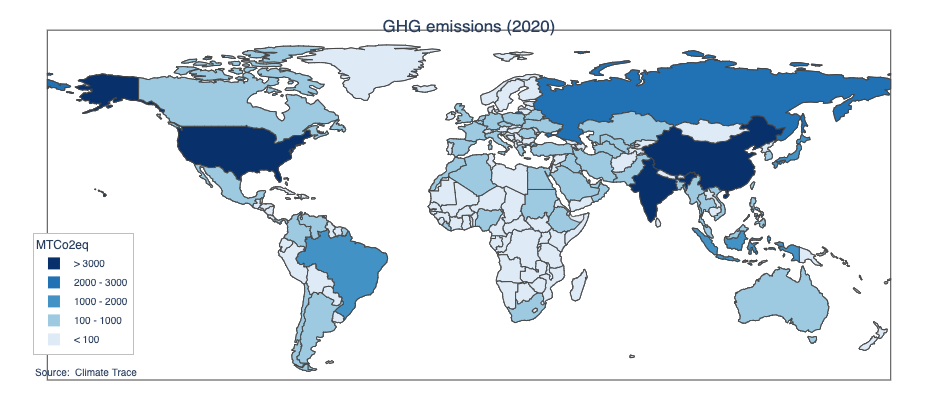

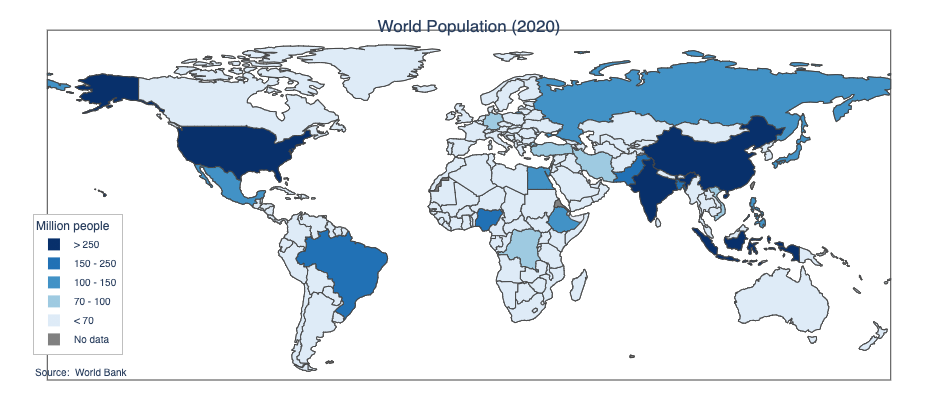

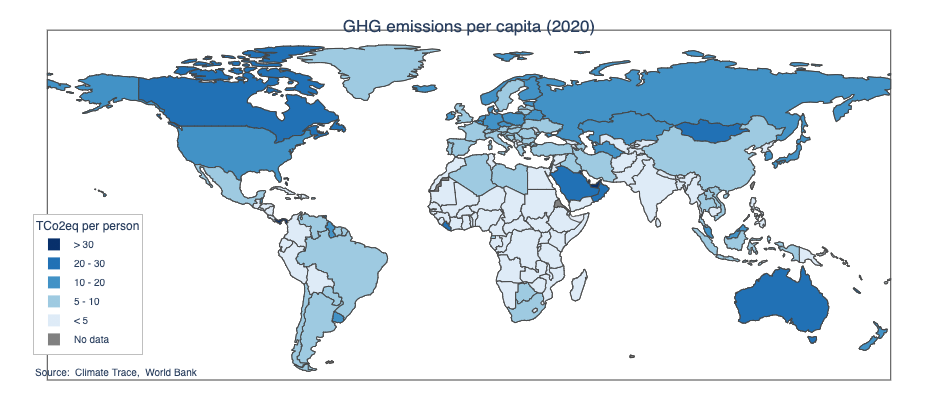

In [33]:
for metric in metrics:
    show_map(metric, '2020', 'html')

#### Maps sector

In [21]:
def percentiles_sector (df, sector):
    
    percentiles=[0]
    
    if sector == 'agriculture':
        values = [50, 100, 200, 500]     
    if sector == 'buildings':
        values = [25, 50, 100, 500]
    if sector == 'extraction':
        values = [1, 3, 5, 7]  
    if sector == 'manufacturing':
        values = [30, 100, 500, 1000]
    if sector == 'maritime':
        values = [1, 10, 50, 100]
    if sector == 'oil and gas':
        values = [25, 100, 500, 1000]
    if sector == 'power':
        values = [25, 50, 100, 1000]
    if sector == 'transport':
        values = [25, 50, 100, 500]     
    if sector == 'waste':
        values = [20, 50, 100, 500]
        
    for val in values:
        percentile = stats.percentileofscore(df['million_tonnes_co2e'], val) / 100
        percentiles.append(percentile)
    
    percentiles.append(1)
            
    values = values[::-1]
    values = [str(val) for val in values]
    legend_values = list(range(len(values) + 1))
    
    legend_values[0] = '> ' + values[0]
    legend_values[1] = values[1]+ ' - ' + values[0]
    legend_values[2] = values[2]+ ' - ' + values[1]
    legend_values[3] = values[3]+ ' - ' + values[2]
    legend_values[4] = '< ' + values[3]
    return legend_values, percentiles

In [22]:
def df_sector(sector, year):
    
    ghg_year = ghg[(ghg.year ==year) & (ghg.sector ==sector)]
    
    
    ghg_map= ghg_year.groupby(['country_full'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
    legend_values, percentiles  = percentiles_sector(ghg_map, sector)
        
    ghg_map['range']=pd.qcut(ghg_map['million_tonnes_co2e'], q=percentiles, precision = 0, labels=False)
    ghg_map = ghg_map.sort_values(by='range', ascending=False)
    ghg_map['million_tonnes_co2e'] =ghg_map['million_tonnes_co2e'].round(1)
    ghg_map['million_tonnes_co2e'] =ghg_map.apply(lambda x: "{:,}".format(x['million_tonnes_co2e']), axis=1)
    ghg_map['million_tonnes_co2e'] = ghg_map['million_tonnes_co2e'].astype(str)
    ghg_map['million_tonnes_co2e']= ghg_map['million_tonnes_co2e'].replace({'nan':'No data'})
    dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
    dictionary['No data'] ='No data'
    ghg_map= ghg_map.replace({"range": dictionary})
    
    ghg_subsector = ghg_year.groupby(['country_full','subsector'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
    ghg_subsector= ghg_subsector.pivot_table(values='million_tonnes_co2e',columns='subsector',index='country_full').reset_index()
    ghg_subsector = ghg_subsector.round(1)
    ghg_map= ghg_map.merge(ghg_subsector, on='country_full',how='left')
    
    return ghg_map


        

In [28]:
def show_map_sector(sector, year, map_format='img'):
    scale = ['rgb(8,48,107)','rgb(33,113,181)','rgb(66,146,198)','rgb(158,202,225)','rgb(222,235,247)','grey']

    ghg_map = df_sector(sector, year)
    hover_data = {'million_tonnes_co2e':True, 'country_full':False,'range':False,}

    for col in ghg_map.columns[3:]:
        hover_data[col]=True
    

    title = 'GHG emissions'
    label = 'Emissions from {sector}'.format(sector=sector)
    measure= 'MTCo2eq'
    source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>'
    hover_info= 'Hover over countries to see GHG emissions by subsector'

    fig = px.choropleth(ghg_map, locations="country_full", 
                        locationmode='country names', color='range',
                        hover_name="country_full",
                        hover_data=hover_data,
                        color_discrete_sequence=scale,
                        labels={'million_tonnes_co2e': label})
                       
    fig.update_layout(autosize=False, 
                      width=800, 
                      height=400,
                      font_family="sans-serif",
                      title_font_family="sans-serif",
                      
                      margin=dict(
                                  l=20,
                                  r=20,
                                  b=20,
                                  t=20,
                                  ),
                        
                      hoverlabel=dict(
                                  bgcolor="white",
                                  font_size=10,
                                  font_family="sans-serif"
                                    ),
                      
                      title=dict(
                                 text= "{title} from {sector} ({year})".format(title = title, sector=sector, year=year),
                                 xanchor = 'center',
                                 x=0.5,
                                 yanchor = 'top',
                                 y=0.95),
                      
                      geo=dict(
                              showframe=True,
                                lataxis=dict(range=[-55,90]),
                              showlakes=False),
                      
                      legend=dict(
                                y=0.07,
                                font_size=10,
                                title=measure,
                                x=0.015,
                                bordercolor="grey",
                                borderwidth=0.5
                                ),
                      
                      annotations = [dict(
                                x=0.015,
                                y=0,
                                text=source,
                                font_size=10,
                                font_family='sans-serif',
                          
                                showarrow = False),
                                    dict(
                                x=1,
                                y=0,
                                text=hover_info,
                                font_size=10,
                                font_family='sans-serif',
                                showarrow = False)])
    if map_format=='img':
        fig.write_image("./img_visualisations/{sector}_{year}.jpeg".format(sector=sector, year=year))
    elif map_format =='html':
        fig.write_html("./html_visualisations/{sector}_{year}.html".format(sector=sector, year=year))


    fig.show()
    

In [24]:
sectors = ghg.sector.unique()

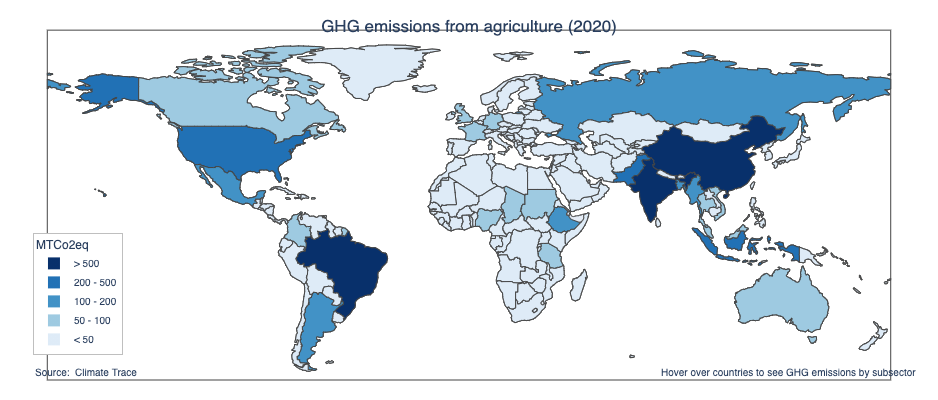

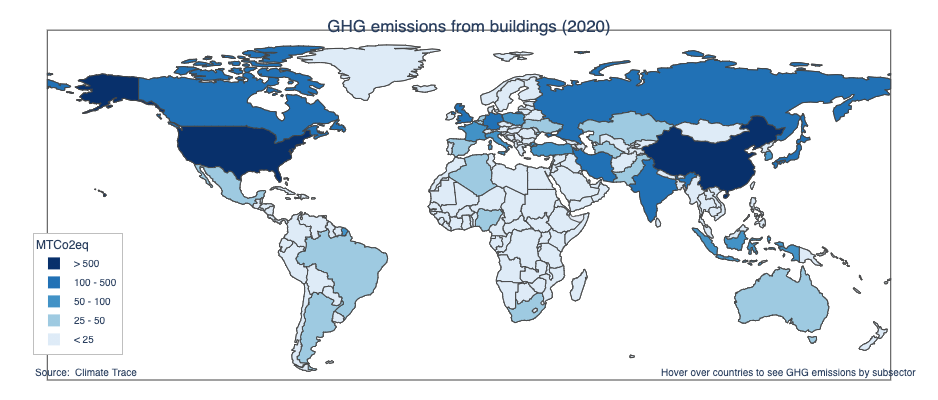

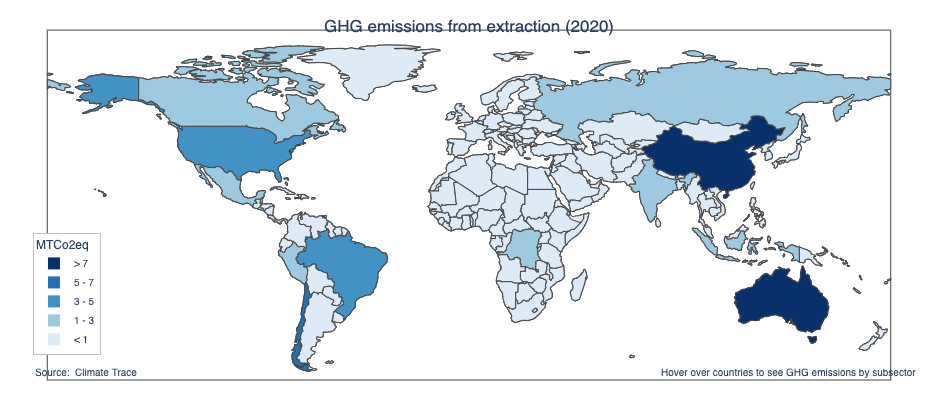

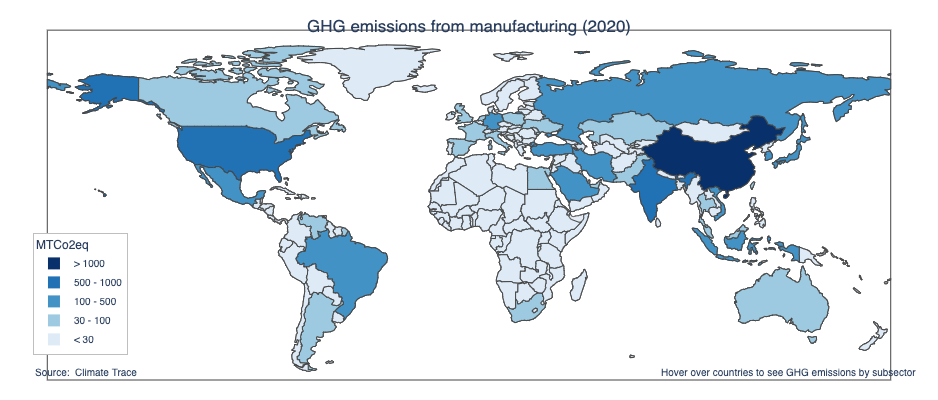

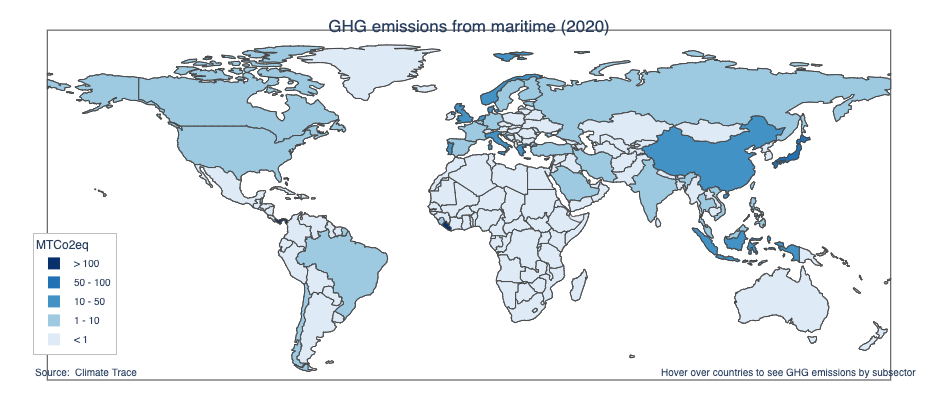

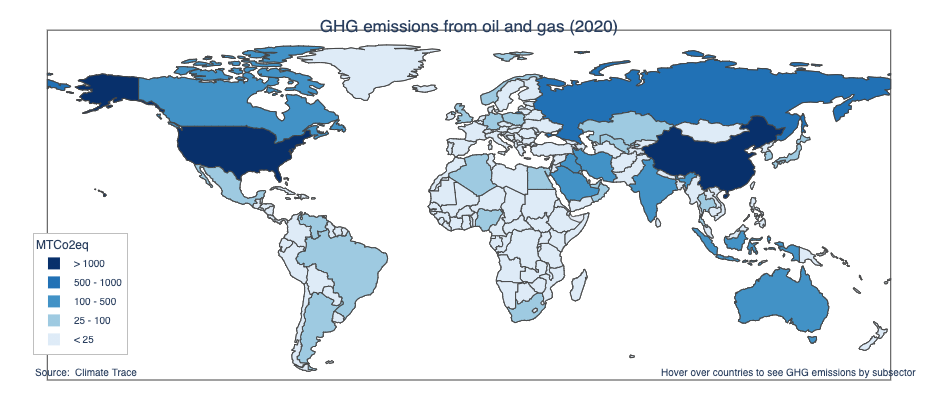

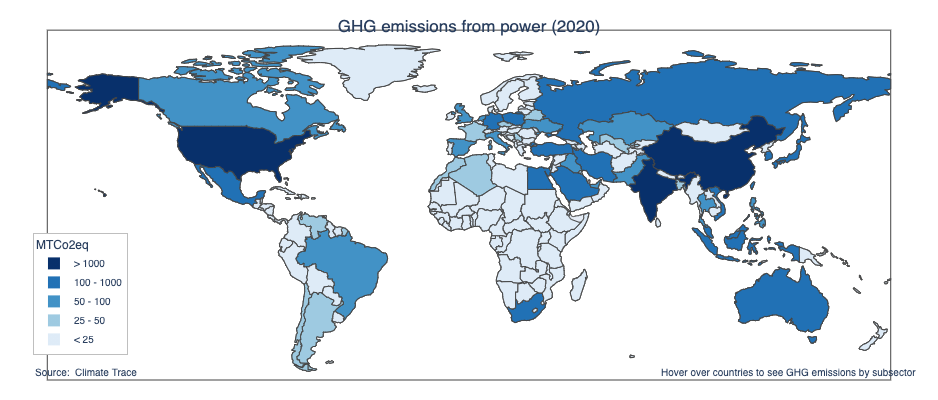

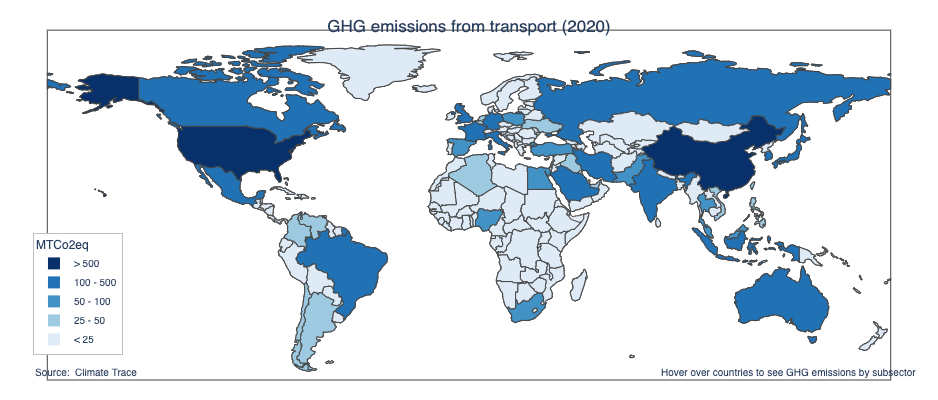

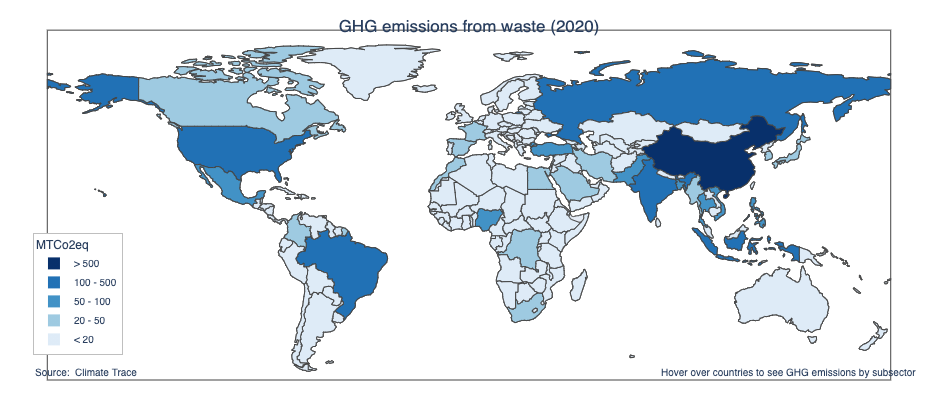

In [30]:
for sector in sectors:
    show_map_sector(sector, '2020','html')